In [1]:
#Generate data
import numpy as np

n = 100
synthetic_data = np.empty((n*n,3))

x = np.linspace(1,20,n)
y = np.linspace(10,40,n)

for i in range(n):
    for j in range(n):
        synthetic_data[i+j*n-1,:] = np.array([x[i],y[j],(x[i]-10.0)**2-(y[j]-15)**2])

#Shuffle contents
np.random.shuffle(synthetic_data)

<IPython.core.display.Javascript object>


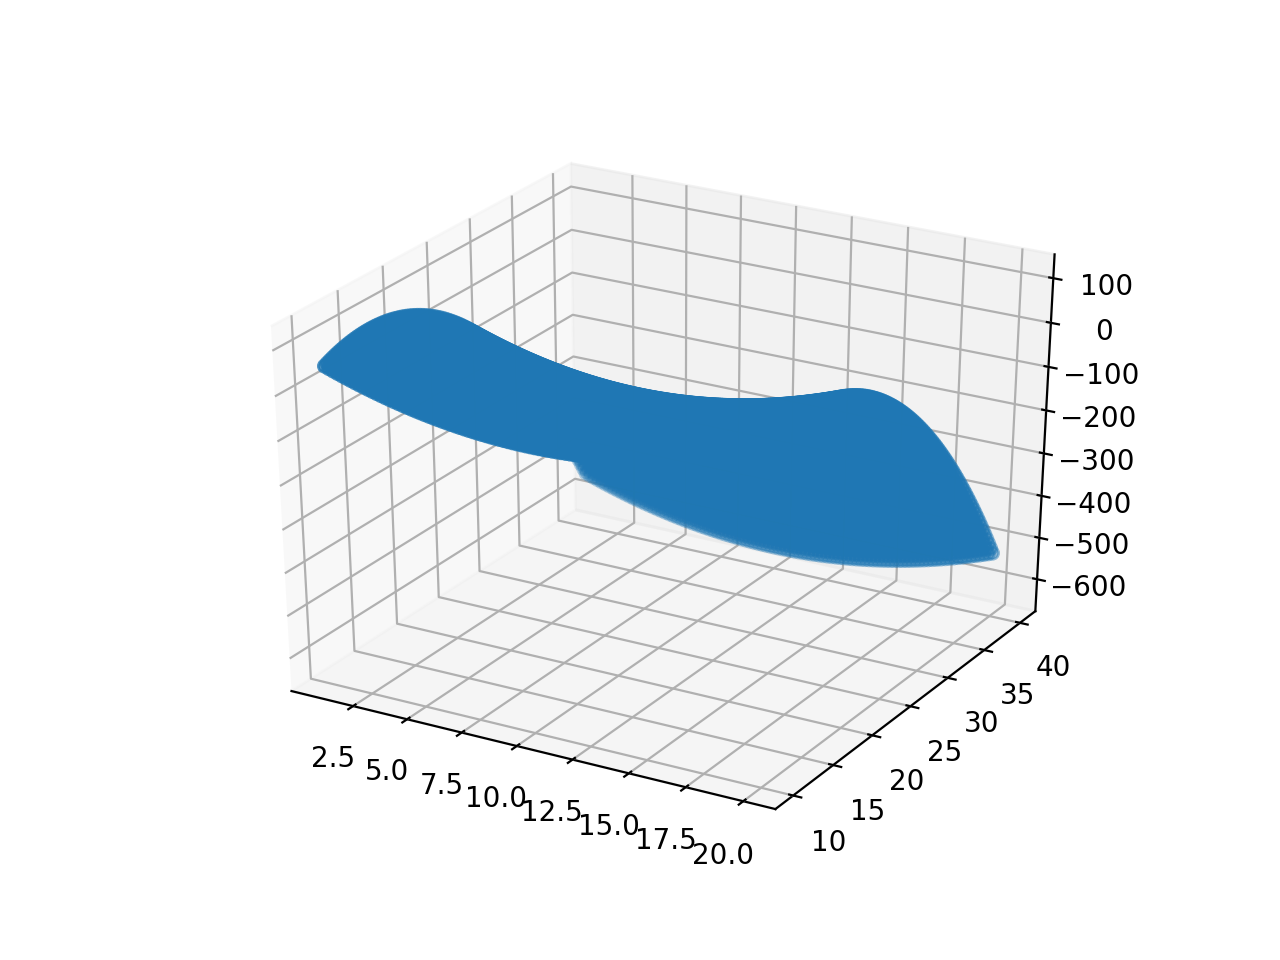

In [2]:
#Graph this data to be sure it is what we want
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(synthetic_data[:,0], synthetic_data[:,1], synthetic_data[:,2])

In [3]:
#Helper functions
def normalise(x):
    """Convert values to range 0-1"""
    x_h = (x - x.min())*1.0 / (x.max() - x.min())
    
    return x_h, x.min(), x.max()

def un_normalise(x_h, x_min, x_max):
    """Convert values from range 0-1 back to normal"""
    x = (x_max-x_min)*x_h + x_min
    
    return x

In [8]:
#Now let's try with an autoencoder
import tensorflow as tf
#Prepare for training and validation with a 70:30 split
split_size = int(synthetic_data.shape[0]*0.7)

#Normalise values
x_in, x_min, x_max = normalise(synthetic_data)
#Remember that for autoencoders we don't need to have any targets since the values themselves are the targets
train_x, val_x = x[:split_size], x[split_size:]

#Most online examples use batch training but we are using a small synthetic dataset so online will suffice

# number of neurons in each layer
input_num_units = 3
hidden_num_units = 2
output_num_units = 3

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
x_h = tf.placeholder(tf.float32, [None, output_num_units])


# define weights and biases of the neural network (refer this article if you don't understand the terminologies)

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units])),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units]))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units])),
    'output': tf.Variable(tf.random_normal([output_num_units]))
}

In [16]:
# hidden = ReLu(x*w_h+b_h)
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.tanh(hidden_layer)
#output_layer = hidden*w_o+b_o
output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']
#Define cost
cost = tf.reduce_mean(tf.pow(output_layer - x_h, 2))
cross_entropy = -tf.reduce_sum(output_layer*tf.log(x_h))
#Choose Optimiser
optimiser = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


n_rounds = 10000
batch_size = 50

In [17]:
for i in range(n_rounds):
    sample = np.random.randint(n*n, size=batch_size)
    batch_xs = x_in[sample][:]
    batch_ys = x_in[sample][:]
    sess.run(optimiser, feed_dict={x: batch_xs, x_h:batch_ys})
    if i % 100 == 0:
        print i, sess.run(cross_entropy, feed_dict={x: batch_xs, x_h:batch_ys}), sess.run(cost, feed_dict={x: batch_xs, x_h:batch_ys})

0 48.1504 5.46103
100 26.6339 0.113278
200 37.9478 0.10137
300 32.2434 0.0665117
400 35.636 0.0646219
500 31.4282 0.0388694
600 32.9774 0.0411112
700 27.8799 0.0267553
800 32.39 0.0271008
900 26.6986 0.0155848
1000 25.6438 0.0151421
1100 28.7109 0.014164
1200 26.4182 0.0117499
1300 26.9335 0.00873335
1400 26.6186 0.00975187
1500 25.3199 0.010004
1600 27.2895 0.0104585
1700 25.6265 0.00757225
1800 25.1934 0.00707525
1900 24.6323 0.00641284
2000 22.8929 0.00683604
2100 23.5566 0.00685973
2200 25.2856 0.0072888
2300 24.0945 0.0068513
2400 23.4129 0.00596184
2500 25.1179 0.00662943
2600 25.1935 0.00673172
2700 23.4556 0.0047576
2800 22.8056 0.00528513
2900 22.9496 0.00583513
3000 24.5818 0.00634598
3100 22.6843 0.00645175
3200 21.5645 0.00482918
3300 23.1144 0.005705
3400 22.6746 0.00466701
3500 22.2765 0.00407051
3600 23.3897 0.00484612
3700 23.6461 0.00597468
3800 23.8437 0.00449212
3900 22.032 0.00396962
4000 21.4328 0.00417082
4100 22.0154 0.00433274
4200 23.0293 0.00352428
4300 24.129

array([ 0.8759176 ,  0.9043128 ,  0.52615609])